<h1><center>Desmystifying Curvelets</center></h1>
<h2><center>An Introduction</center></h2>
<h3><center>Carlos Costa (<a href="https://github.com/cako">@cako</a>)</center></h3>
<h4><center>January 2023</center></h4>

<hr>

<h3>Introduction</h3>

Curvelets are multiscale, oriented, non-adaptive representations of images and volumes. Developed in the early 2000s by Emmanuel Candès and David Donoho, in the flurry of wavelet-transform related signal processing boom, curvelets solved some issues that other multidimensional wavelet transforms had.
Wavelets generalize the 1D Fourier transform by using arbitrary—but especially crafted—functions instead of complex exponentials. They can be readily extended to 2D by simply applying the transform in the new axis. This however, turns out to not be optimal, as they are not particularly efficient in representing edges. This can be manifested in practice as "blocking" artifacts in strongly compressed JPEG images. In addition, curvelets have some nice properties, such as being the optimal representation of wave-like phenomena, preserving energy, having its adjoint (transpose) be the same as its inverse, among others.

Today, they are used in a variety of image-processing tasks including denoising, compression, inpainting, smoothing, etc. In the geophysical community, it has become a powerful workhorse for several tasks including adaptive subtraction, image matching, preconditioning, among others.
While it is true that many deep learning has become the most widely used tool for many of these tasks, curvelets (and other wavelet transforms) still have their use.
Whereas deep learning offers the possibility to create adaptive, multiscale representations of signals, curvelets already offer that without training in predictable ways that are mathematically optimal in many ways.
Whereas most deep-learning methods required large amounts of data for training, one may use curvelets directly as a substitute when no training data is available, or even employ hybrid methods which use curvelet coefficients as features, reducing model complexity and data requirements.


In this tutorial, we will go over the building blocks of the curvelet transform, focusing on the intuition behind it.
The goal is to provide a starting point for users interested in developing new applications which use curvelets.

### Interpretation of the N-dimensional Fourier Transform

To understand the curvelet transform, we need to first understand the 2D FFT.
The 2D FFT tells us what kind of spatial frequencies an image has.
The more energy on the larger wavenumbers (away from the center), the faster the image varies along a certain direction. In this section we will understand how to find this direction, as well as how to quantify "fast".

Let's start by creating images which vary rapidly in the one direction, but not at all in the other These will be helpful in understanding what the $k$-space spectrum (another name for Fourier domain, the transform domain after applying FFT) is telling us.
We will do so by modulating a cosine in the direction normal to a vector $\overrightarrow{v} = (\sin{\theta}, \cos{\theta})$.

In [1]:
from math import ceil, floor

import matplotlib.pyplot as plt
import numpy as np
from pylops.signalprocessing import FFT2D
from pylops.utils.tapers import taper2d
from scipy.signal import filtfilt

plt.rcParams.update({"image.interpolation": "blackman"})

In [2]:
%load_ext watermark
%watermark --iversions

matplotlib: 3.6.3
sys       : 3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
numpy     : 1.23.2



In [3]:
def generate_monochromatic_2d(
    theta_deg: float = 0,
    nx: int = 101,
    nz: int = 101,
    freq: float = 10,
    taper: bool = False,
):
    x = np.linspace(-1, 1, nx)
    z = np.linspace(-1, 1, nz)
    dx, dz = x[1] - x[0], z[1] - z[0]
    xm, zm = np.meshgrid(x, z, indexing="ij")
    theta = np.deg2rad(theta_deg)
    vec = np.array([np.sin(theta), np.cos(theta)])
    img = np.cos(2 * np.pi * freq * (vec[0] * xm + vec[1] * zm))

    if taper:
        img *= taper2d(*img.shape, [nx // 5 + 1, nz // 5 + 1])
    return img, x, z, vec

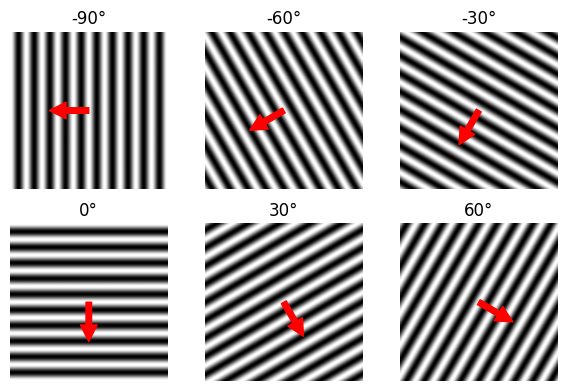

In [4]:
nthetas = 6
frequency = 5
thetas = np.linspace(-90, 60, nthetas)

cols = ceil(np.sqrt(nthetas))
rows = ceil(nthetas / cols)
fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
for theta, ax in zip(thetas, axes.ravel()):
    img, x, z, vec = generate_monochromatic_2d(theta, freq=frequency)
    ax.imshow(
        img.T, vmin=-1, vmax=1, cmap="gray", extent=[x[0], x[-1], z[-1], z[0]]
    )
    ax.set_title(f"{theta:.0f}°")
    ax.annotate(
        f"",
        xy=(vec[0] * 0.5, vec[1] * 0.5),
        xytext=(0, 0),
        arrowprops=dict(edgecolor="r", facecolor="r"),
    )
for ax in axes.ravel():
    ax.axis("off")
fig.tight_layout()

Each plot in this image has an arrow pointing towards the direction of maximum variation $\overrightarrow{v}$. Along the direction perpendicular to it, the signal does not vary at all.

This won't always happen, signals can vary in more than one direction at once. The question is, which directions? And how do we find out? Cue the FFT transform. Let's take one of these images, say the one at 45°, and apply the 2D FFT.

In [5]:
img, x, z, vec = generate_monochromatic_2d(45)
dx, dz = x[1] - x[0], z[1] - z[0]

F2D = FFT2D(
    img.shape,
    sampling=(dx, dz),
    ifftshift_before=True,
    fftshift_after=True,
    norm="ortho",
    real=False,
)
kx = F2D.f1  # Unit is 1 / (unit of dx)
kz = F2D.f2  # Unit is 1 / (unit of dz)

img_k = F2D @ img

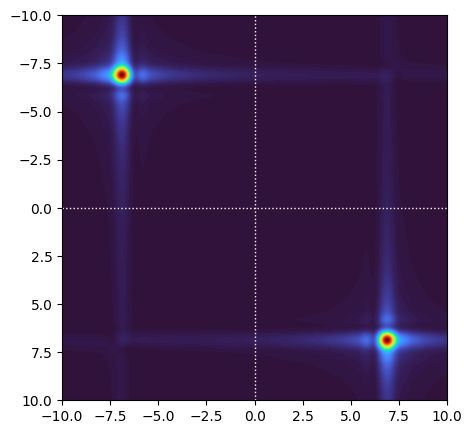

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(
    np.abs(img_k).T,
    vmin=0,
    cmap="turbo",
    extent=[kx[0], kx[-1], kz[-1], kz[0]],
)
ax.set(
    xlim=[-2 * frequency, 2 * frequency], ylim=[2 * frequency, -2 * frequency]
)
ax.axhline(0, ls=":", color="w", lw=1)
ax.axvline(0, ls=":", color="w", lw=1)

In the Fourier domain, we can see that our signal has only a single positive 2D spatial frequency element. A property of the 2D Fourier transform is that for real input signals, the Fourier spectrum is symmetric about the origin. So we can safely "ignore" the negative frequencies. In the above plot, the top-left quadrant carries the same information as the bottom-right quadrant; the top-right carries the same information as the bottom-left quadrant. This is not true for complex signals, but for now we will ignore negative frequencies.

In the (positive $k_z$) $k$-space, we can identify a single peak. Its corresponding $k_x$ and $k_z$ coordinates are given by:

In [7]:
def ndargmax(ary):
    return np.unravel_index(ary.argmax(), ary.shape)


def find_kmax(img_k, kx, kz, unit=False):
    kxmax, kzmax = ndargmax(np.abs(img_k[:, kz >= 0]))
    kvec = np.array([kx[kxmax], kz[kz >= 0][kzmax]])
    if unit:
        kvec /= np.linalg.norm(kvec)
    return kvec

In [8]:
kvec = find_kmax(img_k, kx, kz)
kvec / np.linalg.norm(kvec)

array([0.70710678, 0.70710678])

Comparing it to the vector we used to create this signal,

In [9]:
vec

array([0.70710678, 0.70710678])

we notice that up to a constant, the vectors are the same! Let's try this for all images create above.

1. Compute the 2D FFT
2. Find the maximum amplitude location in k-space
3. $(k_x^\text{max}, k_z^\text{max})$ is the direction of maximum variability of the input

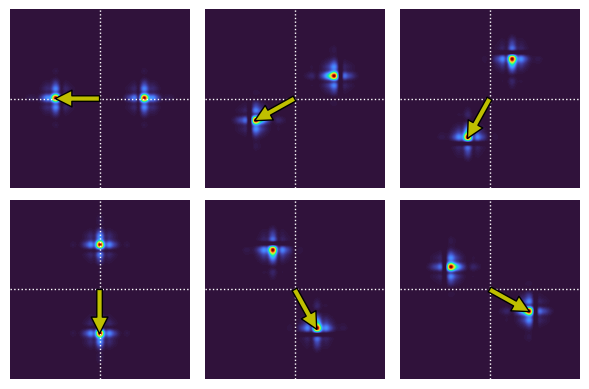

In [10]:
nthetas = 6
frequency = 5
thetas = np.linspace(-90, 60, nthetas)

cols = ceil(np.sqrt(nthetas))
rows = ceil(nthetas / cols)
fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
for theta, ax in zip(thetas, axes.ravel()):
    img, x, z, _ = generate_monochromatic_2d(theta, freq=frequency, taper=True)
    img_k = F2D @ img
    kvec_max = find_kmax(img_k, kx, kz)

    ax.imshow(
        np.abs(img_k).T,
        vmin=0,
        cmap="turbo",
        extent=[kx[0], kx[-1], kz[-1], kz[0]],
    )
    ax.set(
        xlim=[-2 * frequency, 2 * frequency],
        ylim=[2 * frequency, -2 * frequency],
    )
    ax.axhline(0, ls=":", color="w", lw=1)
    ax.axvline(0, ls=":", color="w", lw=1)
    ax.annotate(
        "",
        xy=(kvec_max[0], kvec_max[1]),
        xytext=(0.0, 0.0),
        arrowprops=dict(edgecolor="k", facecolor="y"),
    )
for ax in axes.ravel():
    ax.axis("off")
fig.tight_layout()

Notice how these follow exactly the direction of maximum change in the data. Indeed, if we overlay these normalized vector onto the data-space images, we get:

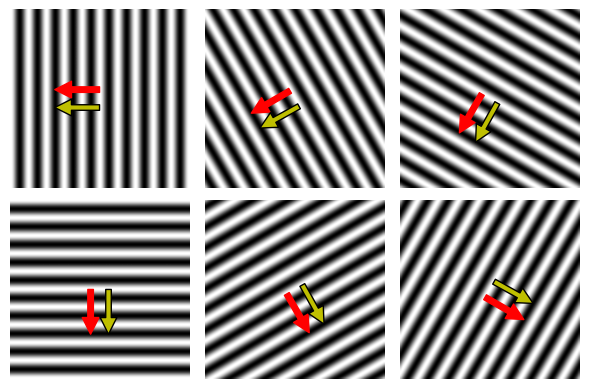

In [11]:
nthetas = 6
frequency = 5
thetas = np.linspace(-90, 60, nthetas)

cols = ceil(np.sqrt(nthetas))
rows = ceil(nthetas / cols)
fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
for theta, ax in zip(thetas, axes.ravel()):
    img, x, z, vec = generate_monochromatic_2d(theta, freq=frequency)

    img_k = F2D @ img
    kvec_max = find_kmax(img_k, kx, kz, unit=True)

    im = ax.imshow(
        img.T, vmin=-1, vmax=1, cmap="gray", extent=[x[0], x[-1], z[-1], z[0]]
    )
    norm = 0.5
    offset = 0.1 * np.array([vec[1], -vec[0]])
    ax.annotate(
        "",
        xy=(-offset[0] + vec[0] * norm, -offset[1] + vec[1] * norm),
        xytext=-offset,
        arrowprops=dict(edgecolor="r", facecolor="r"),
    )
    ax.annotate(
        "",
        xy=(offset[0] + kvec_max[0] * norm, offset[1] + kvec_max[1] * norm),
        xytext=offset,
        arrowprops=dict(edgecolor="k", facecolor="y"),
    )
for ax in axes.ravel():
    ax.axis("off")
fig.tight_layout()

Looks good! What does this have to do with the curvelet transform? Well, imagine we try applying the same method to the following signal:

In [12]:
img_lo, *_ = generate_monochromatic_2d(
    -15,
    freq=0.15 * np.abs(kz).max(),
    taper=True,  # taper prevents Gibb's effect
)
img_hi, *_ = generate_monochromatic_2d(
    15, freq=0.75 * np.abs(kz).max(), taper=True
)
img = 0.4 * img_lo + 0.6 * img_hi
img_k = F2D @ img

vmax = 0.75 * np.abs(img).max()
vmax_k = 0.5 * np.abs(img_k).max()

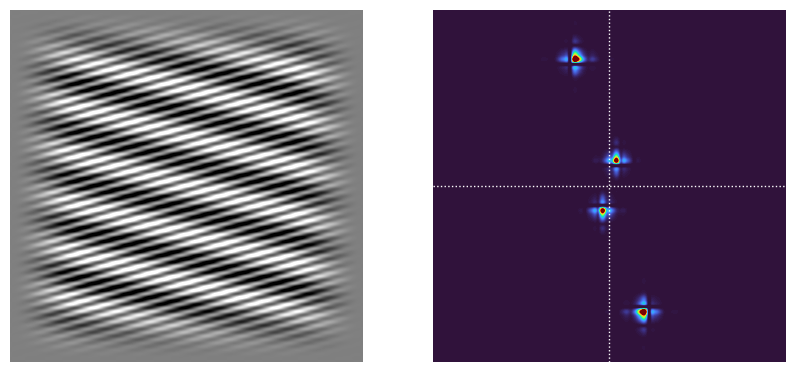

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(
    img.T,
    vmin=-vmax,
    vmax=vmax,
    cmap="gray",
    extent=[x[0], x[-1], z[-1], z[0]],
)
axes[1].imshow(
    np.abs(img_k).T,
    vmin=0,
    vmax=vmax_k,
    cmap="turbo",
    extent=[kx[0], kx[-1], kz[-1], kz[0]],
)
axes[1].axhline(0, ls=":", color="w", lw=1)
axes[1].axvline(0, ls=":", color="w", lw=1)
for ax in axes.ravel():
    ax.axis("off")

We can see that there is a low-frequency signal in the background, corresponding to the -15° component. Atop it, there is a high frequency component in the other direction (15°). If we apply our kmax algorithm, because the low-frequency signal is weaker, it won't get picked up. We will think that our signal's only direction is 15 degrees. But the FFT spectrum has all the information, so what can we do with it?

### Separating scales

The curvelet transform handles this wealth of information by separating the signal at different *scales*, which are defined as concentric regions in the $k$-space domain. These regions will encompass frequencies that are similar. Let's apply this concept to the example above:

In [14]:
def build_lowpass(kx, kz, nsmooth=None):
    if nsmooth is None:
        nsmooth = 0.01 * min(len(kx), len(kz))
        nsmooth = 2 * max(1, floor(nsmooth / 2)) + 1
    mask = np.zeros((len(kx), len(kz)))
    KX, KZ = np.meshgrid(kx, kz, indexing="ij")
    kxnyq = np.abs(kx).max()
    kznyq = np.abs(kz).max()
    inside_scale = (np.abs(KX) < 0.5 * kxnyq) & (np.abs(KZ) < 0.5 * kznyq)
    mask[inside_scale] = 1.0
    s = np.ones((nsmooth,)) / nsmooth
    mask = filtfilt(s, 1, mask, axis=0)
    mask = filtfilt(s, 1, mask, axis=1)
    return mask


lowpass = build_lowpass(kx, kz)
highpass = 1.0 - lowpass

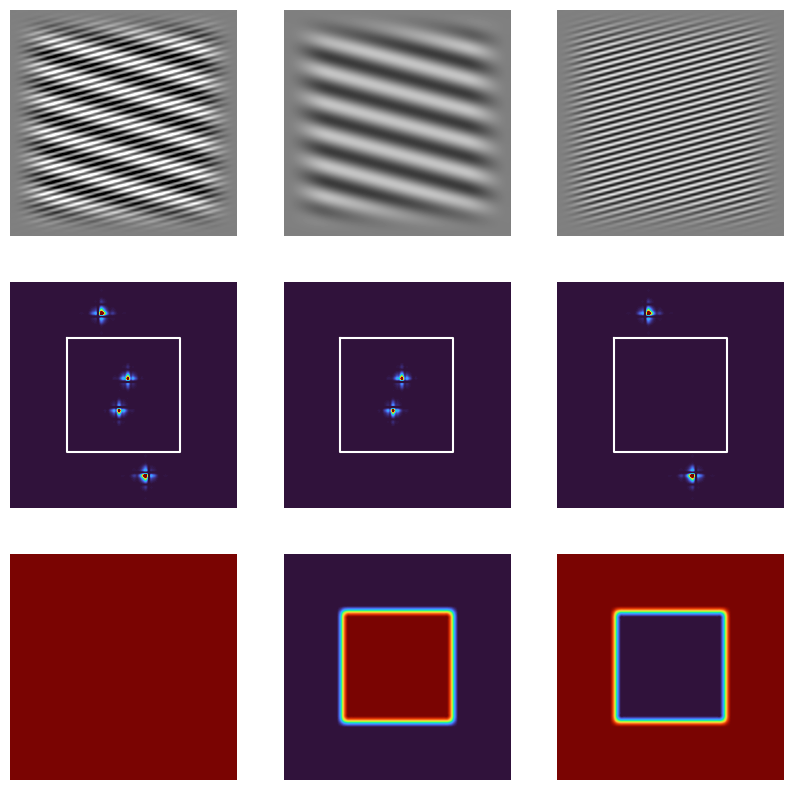

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, _mask in enumerate(
    [lowpass + highpass, lowpass, highpass],
):
    _img_k = _mask * img_k
    _img = (F2D @ _img_k).real
    axes[0, i].imshow(
        _img.T,
        vmin=-vmax,
        vmax=vmax,
        cmap="gray",
        extent=[x[0], x[-1], z[-1], z[0]],
    )
    axes[1, i].imshow(
        np.abs(_img_k).T,
        vmin=0,
        vmax=vmax_k,
        cmap="turbo",
        extent=[kx[0], kx[-1], kz[-1], kz[0]],
    )
    kxnyq = 0.5 * np.abs(kx).max()
    kznyq = 0.5 * np.abs(kz).max()
    axes[1, i].plot(
        [-kxnyq, kxnyq, kxnyq, -kxnyq, -kxnyq],
        [-kznyq, -kznyq, kznyq, kznyq, -kznyq],
        color="w",
    )
    axes[2, i].imshow(
        _mask.T,
        vmin=0,
        cmap="turbo",
        extent=[kx[0], kx[-1], kz[-1], kz[0]],
    )
for ax in axes.ravel():
    ax.axis("off")

The top-left signal is the original input signal.
The image below it (second row) is its the Fourier spectrum.
The image below that (third row) is the "mask" applied to the Fourier spectrum to reconstruct the original signal. It is entirely red, representing ones, that is, no change to the spectrum.

The second column, depicts signals from the first region, constructed by a lowpass filter defined by its mask (third row, middle column). Where it zeroes the signal, the mask is purple.
Finally, the third column depicts the second region, constructed by a highpass filter which is $1 - \text{lowpass}$.

In the curvelet transform, the number of scales is the first parameter. A choice of scales=2 would create a division very similar to the one above (but with a different, special type of smoothing). The more scales there are, the more precise the curvelet transform coefficients will be able to separate signals with different frequencies.

And what will these coefficients be? In this case, something very similar the inverse transform of the lowpass and highpass filters, that is, the two rightmost panels in the top row. The only caveat (in addition to the smoothing) is that the lower frequency scale does not require the same sampling as the original signal. Indeed, the Nyquist frequency (highest frequency that a certain sampling can represent) of the lowpass signal is *half* of the original Nyquist frequency. This is clear from the fact that the lowpass signal removes all frequencies above Nyquist/2. Therefore we could actually *double* the sampling of lowpass component compared to that of the original signal. This is a general rule, and we will see that the coarsest scale (scale = 0) can be sampled at $2^{n_\text{scales} - 1}$ times the original sampling.

The finest scale (in this example, scale = 1) cannot be treated the same way, as its highest frequency remains the frequency of the original signal.

For visualization's sake, we can apply this resampling to the lower frequency scale to get an idea of what the curvelet coefficients would look like for a nscales=2 and no additional subdivisions (more about this soon).

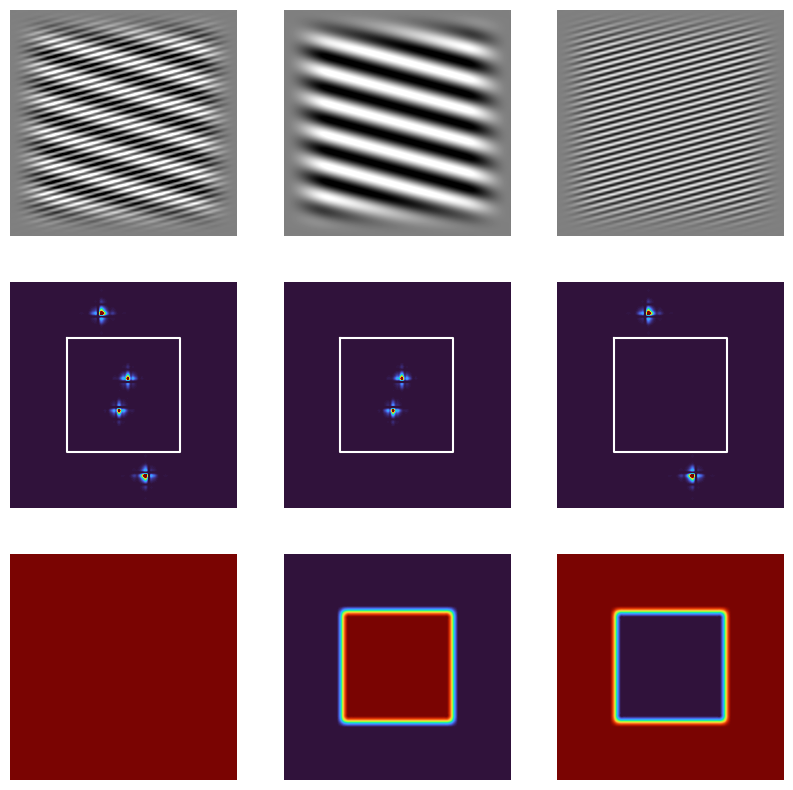

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, _mask in enumerate(
    [lowpass + highpass, lowpass, highpass],
):
    _img_k = _mask * img_k
    if i == 1:  # Coarsest scale
        kxmax = 0.5 * np.abs(kx).max()
        kzmax = 0.5 * np.abs(kz).max()
        _img_k_lp = _img_k[np.abs(kx) < kxmax, :][:, np.abs(kx) < kzmax]
        F2D_lp = FFT2D(
            _img_k_lp.shape,
            sampling=(2 * dx, 2 * dz),
            ifftshift_before=True,
            fftshift_after=True,
            norm="ortho",
            real=False,
        )
        _img = (F2D_lp.H @ _img_k_lp).real
    else:
        _img = (F2D @ _img_k).real
    axes[0, i].imshow(
        _img.T,
        vmin=-vmax,
        vmax=vmax,
        cmap="gray",
        extent=[x[0], x[-1], z[-1], z[0]],
    )
    axes[1, i].imshow(
        np.abs(_img_k).T,
        vmin=0,
        vmax=vmax_k,
        cmap="turbo",
        extent=[kx[0], kx[-1], kz[-1], kz[0]],
    )
    kxnyq = 0.5 * np.abs(kx).max()
    kznyq = 0.5 * np.abs(kz).max()
    axes[1, i].plot(
        [-kxnyq, kxnyq, kxnyq, -kxnyq, -kxnyq],
        [-kznyq, -kznyq, kznyq, kznyq, -kznyq],
        color="w",
    )
    axes[2, i].imshow(
        _mask.T,
        vmin=0,
        cmap="turbo",
        extent=[kx[0], kx[-1], kz[-1], kz[0]],
    )
for ax in axes.ravel():
    ax.axis("off")

Comparing this plot to the original plot without resampling, we notice that the signal is accurately represented in both, but the strength of the resampled signal is larger. This is because the Fourier transform used to "return" to the spatial domain now has a normalization factor which is smaller than the original. Therefore the signal will be $\sqrt{2}\times\sqrt{2}$ times stronger (one square root per dimension, in this case 2). This is also a general rule of the curvelet transform and Fourier transforms.

Let's apply this decomposition to another example.

In [17]:
img_lo, *_ = generate_monochromatic_2d(
    -30, freq=0.9 * np.abs(kz).max(), taper=True
)
img_hi, *_ = generate_monochromatic_2d(
    30, freq=0.9 * np.abs(kz).max(), taper=True
)
img = 0.3 * img_lo + 0.7 * img_hi
img_k = F2D @ img

vmax = 0.75 * np.abs(img).max()
vmax_k = 0.2 * np.abs(img_k).max()

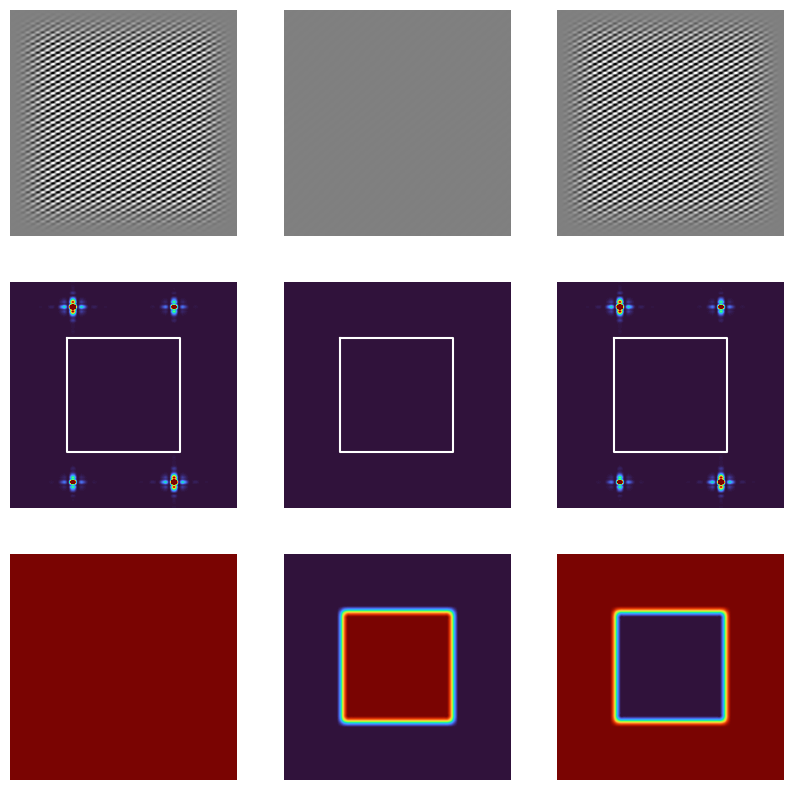

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, _mask in enumerate(
    [lowpass + highpass, lowpass, highpass],
):
    _img_k = _mask * img_k
    _img = (F2D @ _img_k).real
    axes[0, i].imshow(
        _img.T,
        vmin=-vmax,
        vmax=vmax,
        cmap="gray",
        extent=[x[0], x[-1], z[-1], z[0]],
    )
    axes[1, i].imshow(
        np.abs(_img_k).T,
        vmin=0,
        vmax=vmax_k,
        cmap="turbo",
        extent=[kx[0], kx[-1], kz[-1], kz[0]],
    )
    kxnyq = 0.5 * np.abs(kx).max()
    kznyq = 0.5 * np.abs(kz).max()
    axes[1, i].plot(
        [-kxnyq, kxnyq, kxnyq, -kxnyq, -kxnyq],
        [-kznyq, -kznyq, kznyq, kznyq, -kznyq],
        color="w",
    )
    axes[2, i].imshow(
        _mask.T,
        vmin=0,
        cmap="turbo",
        extent=[kx[0], kx[-1], kz[-1], kz[0]],
    )
for ax in axes.ravel():
    ax.axis("off")

### Separating Dips
While we have separated in *scale*, we still are not able to distinguish the two separate events, one at -30° and one at 30°. We need another type subdivision, one which splits a signal (of similar frequencies) further, into "subsignals" of similar direction (or *dip*, in geophysical lingo). Starting with the second scale (the one after the coarsest), we will further split it scale into *wedges*. These are approximately angular sectors in the $k$-space domain. The coarsest scale (scale=0) is exempt from this splitting because the point (0, 0) can't be assigned to a particular wedge, and it is tough to compute filters which handle this discontinuity gracefully.

In [19]:
def build_8wedges_sym(kx, kz, wedge=0, nsmooth=None):
    lopass = build_lowpass(kx, kz, nsmooth=nsmooth)
    if nsmooth is None:
        nsmooth = 0.01 * min(len(kx), len(kz))
        nsmooth = 2 * max(1, floor(nsmooth / 2)) + 1

    mask = np.zeros_like(lopass)
    KX, KZ = np.meshgrid(kx, kz, indexing="ij")
    kxnyq = np.abs(kx).max()
    kznyq = np.abs(kz).max()

    s = 1 if wedge == 0 or wedge == 1 else -1
    K1 = KX if wedge == 0 or wedge == 2 else KZ
    K2 = KZ if wedge == 0 or wedge == 2 else KX
    inside_wedge = (s * (np.abs(K1) - np.abs(K2)) > 0) & (s * KX * KZ > 0)
    mask[inside_wedge] = 1
    mask[inside_wedge] -= lopass[inside_wedge]
    s = np.ones((nsmooth,)) / nsmooth
    mask = filtfilt(s, 1, mask, axis=0)
    mask = filtfilt(s, 1, mask, axis=1)
    return mask


wedges = [build_8wedges_sym(kx, kz, wedge=wedge) for wedge in range(4)]

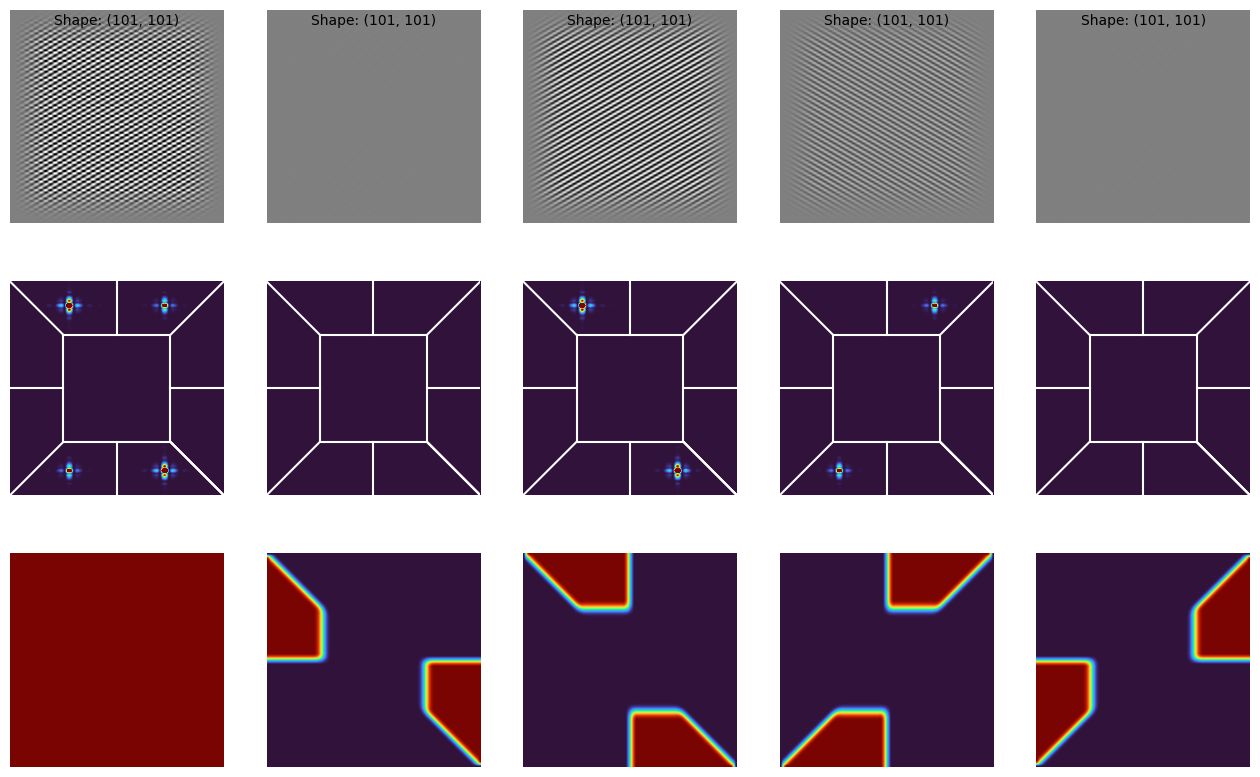

In [20]:
fig, axes = plt.subplots(3, 5, figsize=(16, 10))
for i, _mask in enumerate(
    [lowpass + highpass, *wedges],
):
    _img_k = img_k * _mask
    _img = (F2D.H @ _img_k).real
    axes[0, i].imshow(
        _img.T,
        vmin=-vmax,
        vmax=vmax,
        cmap="gray",
        extent=[x[0], x[-1], z[-1], z[0]],
    )
    axes[0, i].text(
        0.5,
        0.95,
        f"Shape: {_img.shape}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axes[0, i].transAxes,
    )
    axes[1, i].imshow(
        np.abs(_img_k).T,
        vmin=0,
        vmax=vmax_k,
        cmap="turbo",
        extent=[kx[0], kx[-1], kz[-1], kz[0]],
    )
    kxmax = np.abs(kx).max()
    kzmax = np.abs(kz).max()
    axes[1, i].plot(
        0.5 * np.array([-kxmax, kxmax, kxmax, -kxmax, -kxmax]),
        0.5 * np.array([-kzmax, -kzmax, kzmax, kzmax, -kzmax]),
        color="w",
    )
    for s in [1, -1]:
        axes[1, i].plot(
            [s * kxmax, s * 0.5 * kxmax],
            [s * kzmax, s * 0.5 * kzmax],
            color="w",
        )
        axes[1, i].plot(
            [kxmax, 0.5 * kxmax],
            [s * kzmax, s * 0.5 * kzmax],
            color="w",
        )
        axes[1, i].plot(
            [-s * kxmax, -s * 0.5 * kxmax],
            [kzmax, 0.5 * kzmax],
            color="w",
        )
        axes[1, i].plot(
            [0, 0],
            [s * kzmax, s * 0.5 * kzmax],
            color="w",
        )
        axes[1, i].plot(
            [s * kxmax, s * 0.5 * kxmax],
            [0, 0],
            color="w",
        )
    axes[2, i].imshow(
        _mask.T,
        vmin=0,
        cmap="turbo",
        extent=[kx[0], kx[-1], kz[-1], kz[0]],
    )
for ax in axes.ravel():
    ax.axis("off")

We can see that we have been able to separate the signal into its two constituent components. For this signal, two of the wedges are identically zero. The signals in the first row, starting from the second column, are essentially what the curvelet coefficients would look like if we applied the curvelet transform with the parameters `nscales=8` and `nwedges=8`.

One small caveat is that we are actually only showing *4* wedges. This is because of the symmetric of the Fourier domain for real signals. For complex signals, we would have to treat each wedge (without its symmetrical counterpart) separately.

### Fast Discrete Curvelet Transforms

The way in which we have constructed curvelets so far is far from optimal. One issue is the taper: if we sum every wedge mask, we don't get an exact value of 1.0 at every grid point in the $k$-space domain due to the way we tapered. A more pressing issue is performance: the wedges were transformed back to the spatial domain in a non-optimal way, as we used a full-sized FFT transform to transform a small sliver of the $k$-space domain. This results in curvelet coefficients all shaped the same size as our input image (in that example, 101 × 101).

An important property of the continuous curvelet transform is that performing the steps backward to generate an output image from curvelet coefficients, should give you the exact same image that was used to obtain these coefficients. Mathematically, the transformation is unitary, that is, its adjoint is equal to its inverse. Our implementation does not respect this property.

However, it is possible to fix all these issues. One way is the Fast Discrete Curvelet Transforms, developed by Emmanuel Candès, Laurent Demanet, David Donoho and Lexing Ying. Its most famous implementation is provided by the CurveLab package, which the *curvelops* package (disclaimer: I wrote *curvelops*) wraps via Python. *Curvelops* thereby provides a linear operator interface compatible with PyLops (disclaimer: I am one of the core devs of this library).

Let's take the signal we were using, compute the FDCT with curvelops, and compare the curvelet coefficients with what we generated before.

In [21]:
from curvelops import FDCT2D
from curvelops.plot import curveshow

In [22]:
C2D = FDCT2D(img.shape, nbscales=2, nbangles_coarse=8, allcurvelets=True)

# `FDCT2D` returns an unstructured unidimensional vector, we will reorganize the
# coefficients by structuring them as a list of lists. These in turn can be
# indexed as C[scale][wedge][zpos, xpos].
# Note that the `FDCT2D` transposes the dimensions of the original image.
# This is a remnant of the original implementation.
img_c = C2D.struct(C2D @ img)

# In our previous example, we considered a "wedge" to be symmetric with respect
# to the origin. The `FDCT2D` does not do this by default. Moreover, it will always
# output each unsymmetrized wedge separately. In this example, `nbangles_coarse = 8`
# really only gives us 4 independent wedges. We will symmetrize them as follows
for iscale in range(len(img_c)):
    if len(img_c[iscale]) == 1:  # Not a curvelet transform
        print(f"Wedges in scale {iscale+1}: {len(img_c[iscale])}")
        continue
    nbangles = len(img_c[iscale])
    for iwedge in range(nbangles // 2):
        img_c[iscale][iwedge] = (
            img_c[iscale][iwedge]  # Wedge
            + img_c[iscale][iwedge + nbangles // 2]  # Symmetric counterpart
        ) / np.sqrt(2)
    img_c[iscale] = img_c[iscale][: nbangles // 2]
    print(f"Wedges in scale {iscale+1}: {len(img_c[iscale])}")

Wedges in scale 1: 1
Wedges in scale 2: 4


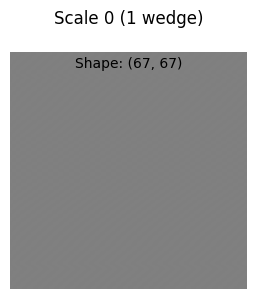

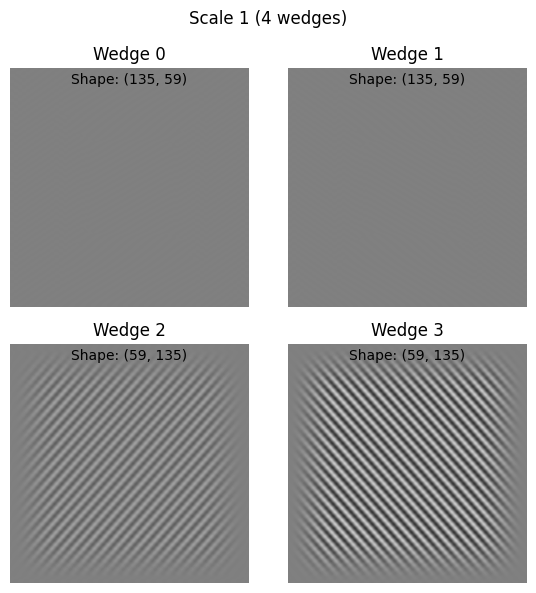

In [23]:
figs_axes = curveshow(
    img_c,
    basesize=3,
    kwargs_imshow=dict(vmin=-1, vmax=1, extent=[x[0], x[-1], z[-1], z[0]]),
)
for c_scale, (fig, axes) in zip(img_c, figs_axes):
    for iwedge, (c_wedge, ax) in enumerate(
        zip(c_scale, np.atleast_1d(axes).ravel())
    ):
        ax.text(
            0.5,
            0.95,
            f"Shape: {c_wedge.shape}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

These look very similar to what we obtained before, with a few differences. First, as mentioned before, the algorithm actually outputted 8 wedges in the second scale; we merged them due to the symmetry of the Fourier space for real input signals. Second, we can see that the shapes are not the same as the input signal. The coarsest scale is about 2/3s of the input signal. On the second scale, not only the sizes are different, but the aspect ratio is also different. This is because different directions require different sampling. The FDCT handles all these issues for us, in a way that is performant and that respects the unitary nature of the continuous transform.

Now we are ready to understand the parameters of the curvelet transform:

* **nbscales** (no default, minimum 2): Number of scales.
  
   The more scales, the finer the details the curvelet transform will capture. The downsides are performance and tapering issues when too many scales are used. Both of these issues can be mitigated by setting `allcurvelets=False`.

* **nbangles_coarse** (default: 16, minimum 8, must be a multiple of 4): Number of angles/wedges at the second coarsest scale.
   
   Remember that the coarsest scales is never subdivided. This value is only specified for the second scale because it will double roughly every two scales. So by setting a `nbscales=5` and `nbangles_coarse=8`, the second scale will have 8 wedges, the third 16, the fourth 16, the last one 32.

* **allcurvelets** (default: True): Controls whether we do wedge subdivisions on the last (finest) scale.
  
   We did this in the latter example, but not in the one before that. From a practical point of view, despite defaulting to True, you should set this options to False unless there is a strong reason not to.

### Examples of the Curvelet transform

Now that we understand these parameters, let's have a look at the some curvelet coefficients from different parameters.

(-0.5, 629.5, 629.5, -0.5)

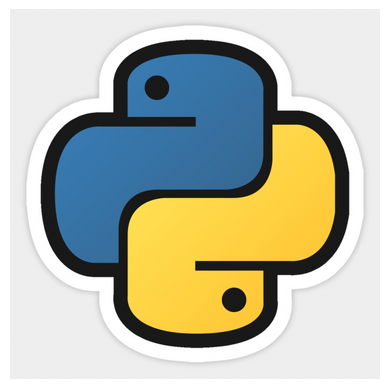

In [24]:
logo = plt.imread("../testdata/python.png", format="PNG")
logo = logo.astype(float)
logo /= 255.0

fig, ax = plt.subplots()
ax.imshow(logo)
ax.axis("off")

Example with

* `nbscales=4`
* `nbangles_coarse=8`
* `allcurvelets=False`

In [25]:
C2D = FDCT2D(
    logo.shape[:-1], nbscales=4, nbangles_coarse=8, allcurvelets=False
)

logo_r = C2D.struct(C2D @ logo[..., 0])
logo_g = C2D.struct(C2D @ logo[..., 1])
logo_b = C2D.struct(C2D @ logo[..., 2])

# Concatenate the curvelet coefficients for each wedge
logo_c = [[] for _ in logo_r]
for iscale, c_angles in enumerate(logo_r):
    logo_c[iscale] = []
    for iwedge, c_wedge in enumerate(c_angles):
        wedges = [
            c[iscale][iwedge][..., np.newaxis].real
            for c in [logo_r, logo_g, logo_b]
        ]
        out = np.concatenate(wedges, axis=-1)
        # Rescaling because the curvelet coefficients are stronger than
        # the original signal due to the FFT normalization
        out *= np.sqrt(logo_r[iscale][iwedge].size / logo[..., 0].size)

        # However, the above scaling may put the signal outside of the [0, 1]
        # interval required for RGB images. As such we will rescale - purely
        # for visualization purposes, values between 0 and 1.
        out = (out - out.min()) / (out.max() - out.min())
        logo_c[iscale].append(out)

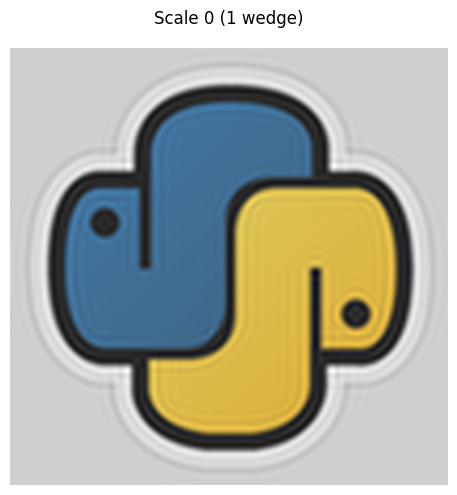

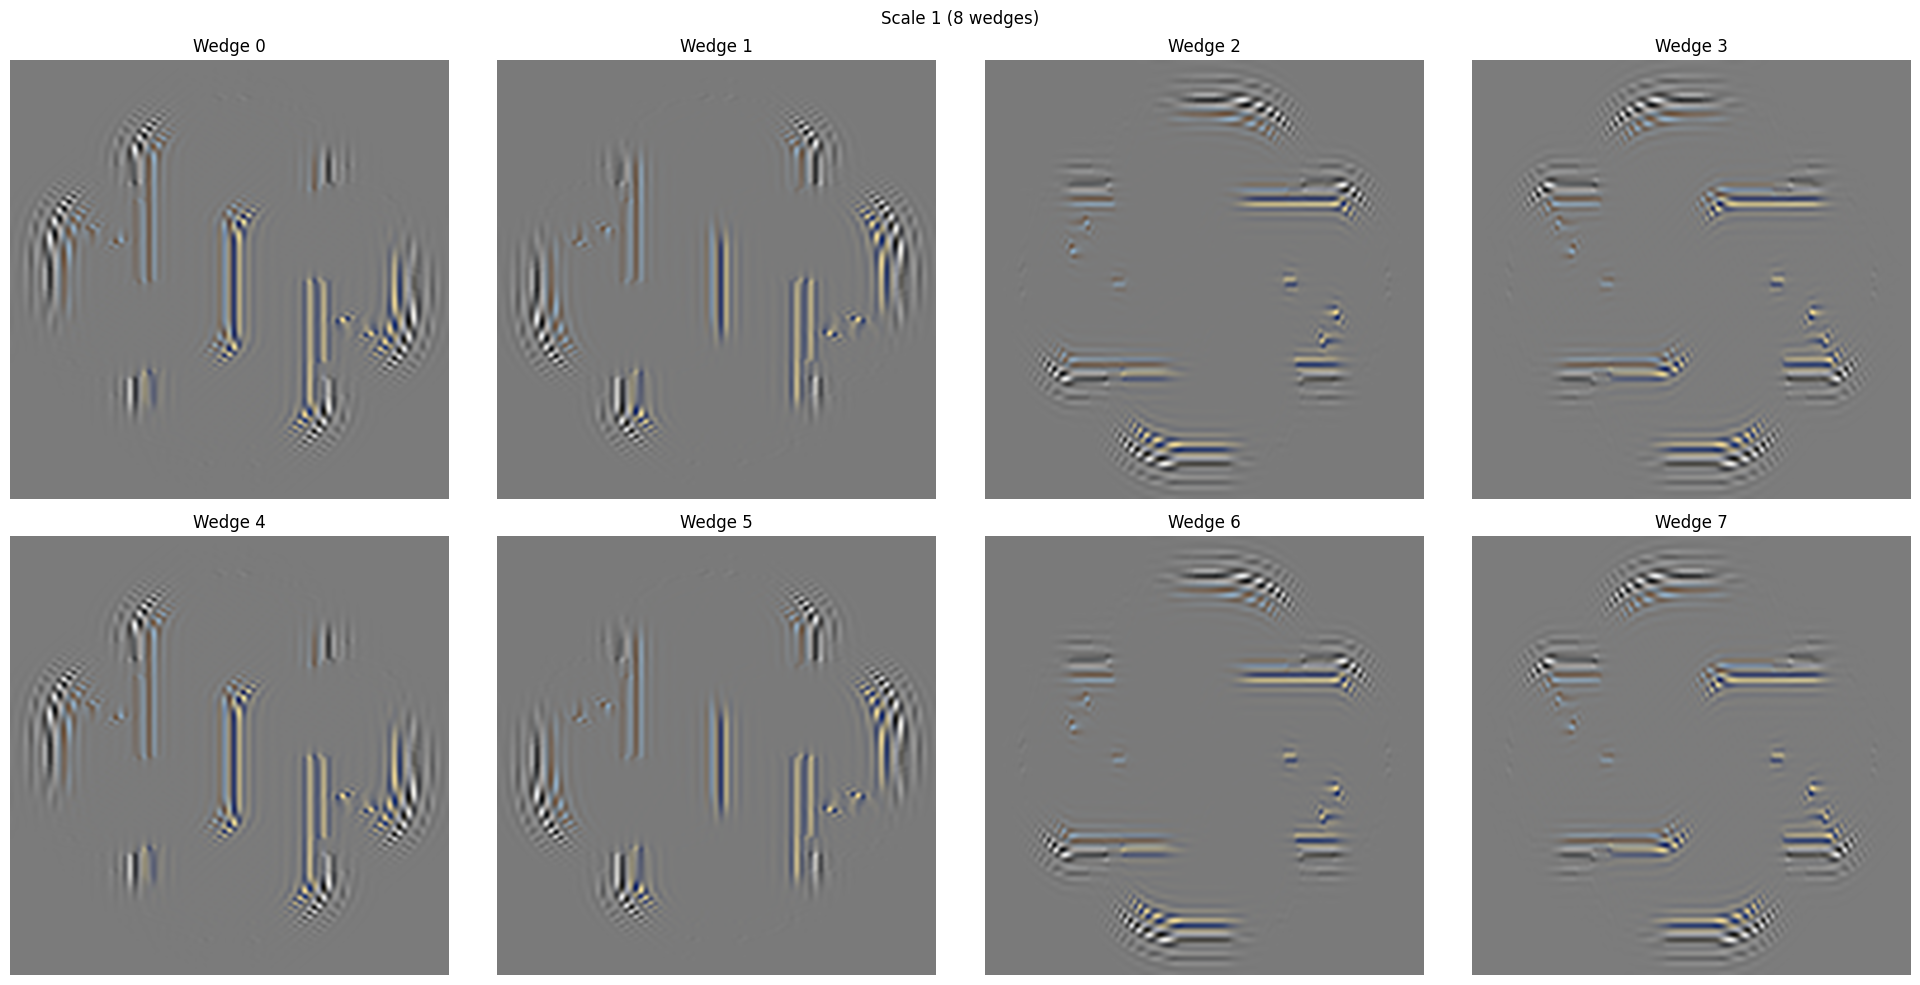

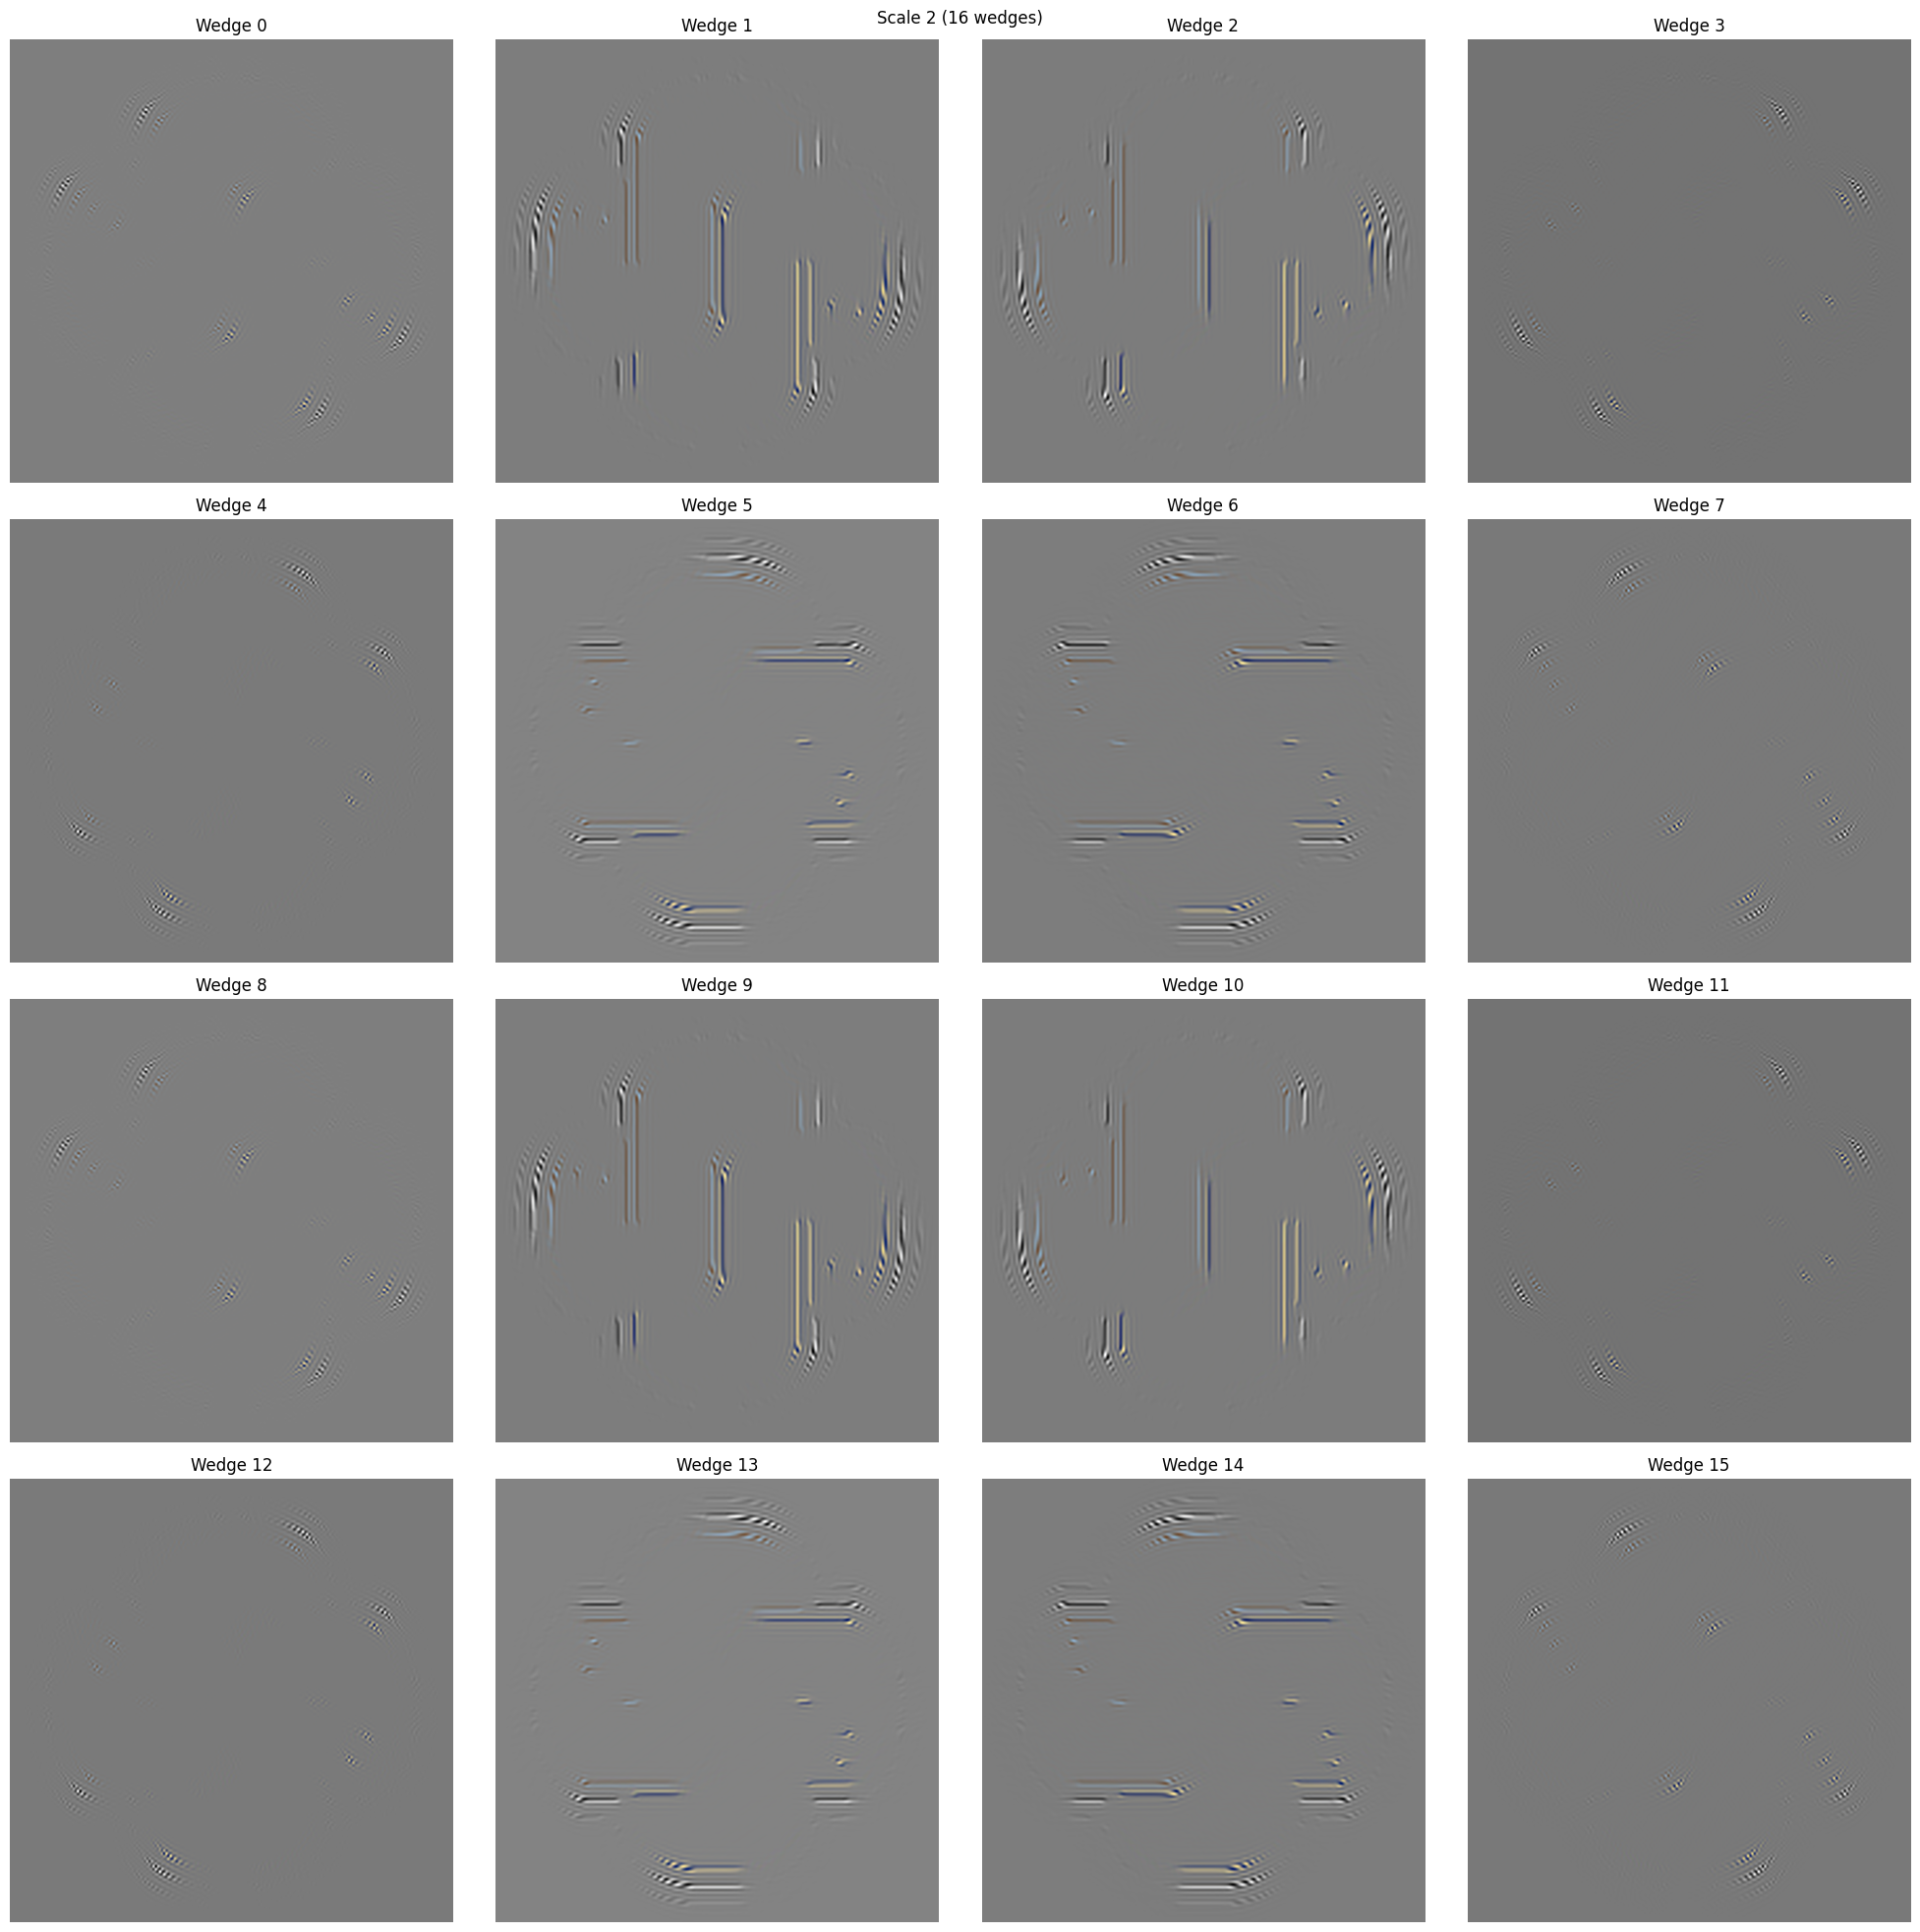

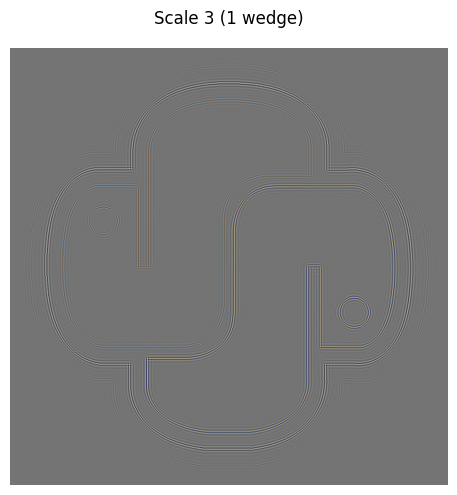

In [26]:
fig_axes = curveshow(
    logo_c,
    kwargs_imshow=dict(extent=[0, 1, 1, 0]),
)

Example with

* `nbscales=3`
* `nbangles_coarse=8`
* `allcurvelets=True`

In [27]:
C2D = FDCT2D(logo.shape[:-1], nbscales=3, nbangles_coarse=8, allcurvelets=True)

logo_r = C2D.struct(C2D @ logo[..., 0])
logo_g = C2D.struct(C2D @ logo[..., 1])
logo_b = C2D.struct(C2D @ logo[..., 2])

# Concatenate the curvelet coefficients for each wedge
logo_c = [[] for _ in logo_r]
for iscale, c_angles in enumerate(logo_r):
    logo_c[iscale] = []
    for iwedge, c_wedge in enumerate(c_angles):
        wedges = [
            c[iscale][iwedge][..., np.newaxis].real
            for c in [logo_r, logo_g, logo_b]
        ]
        out = np.concatenate(wedges, axis=-1)
        # Rescaling because the curvelet coefficients are stronger than
        # the original signal due to the FFT normalization
        out *= np.sqrt(logo_r[iscale][iwedge].size / logo[..., 0].size)

        # However, the above scaling may put the signal outside of the [0, 1]
        # interval required for RGB images. As such we will rescale - purely
        # for visualization purposes, values between 0 and 1.
        out = (out - out.min()) / (out.max() - out.min())
        logo_c[iscale].append(out)

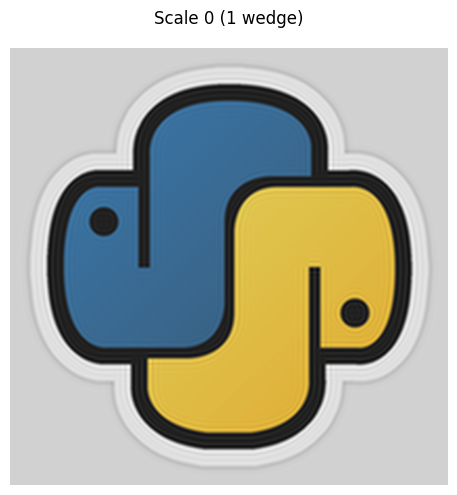

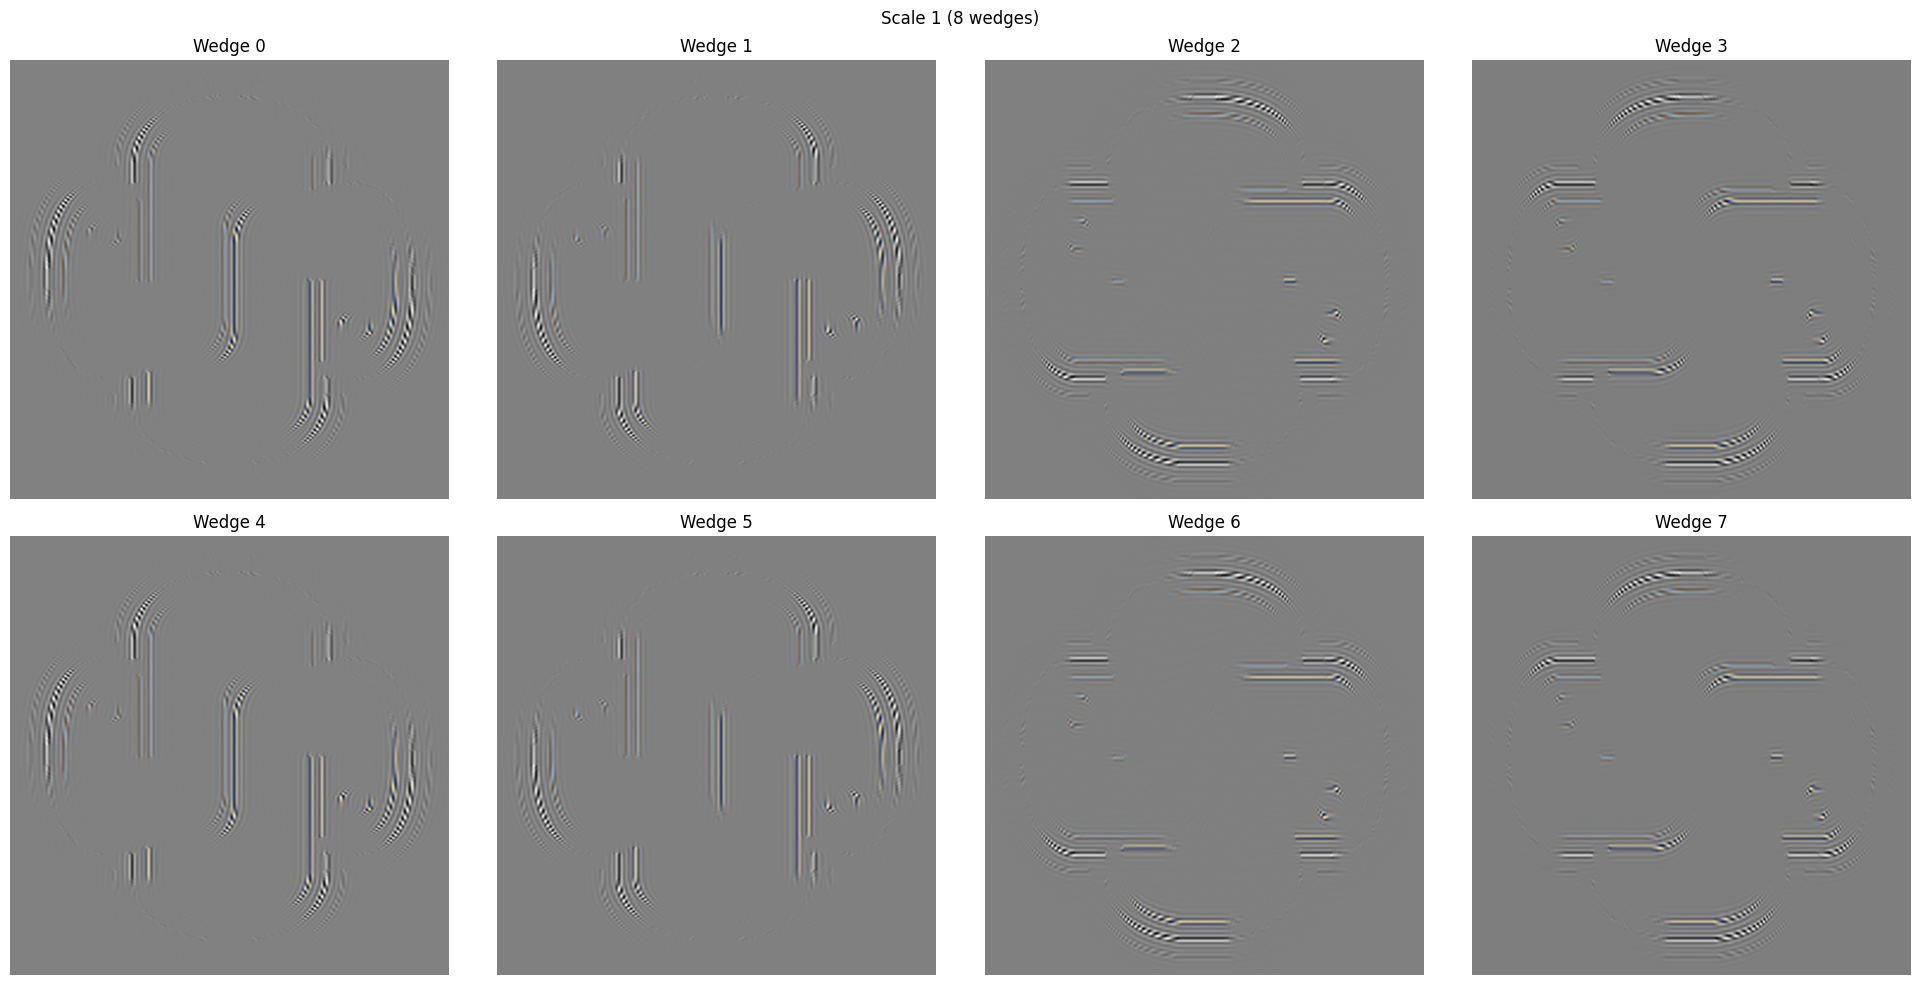

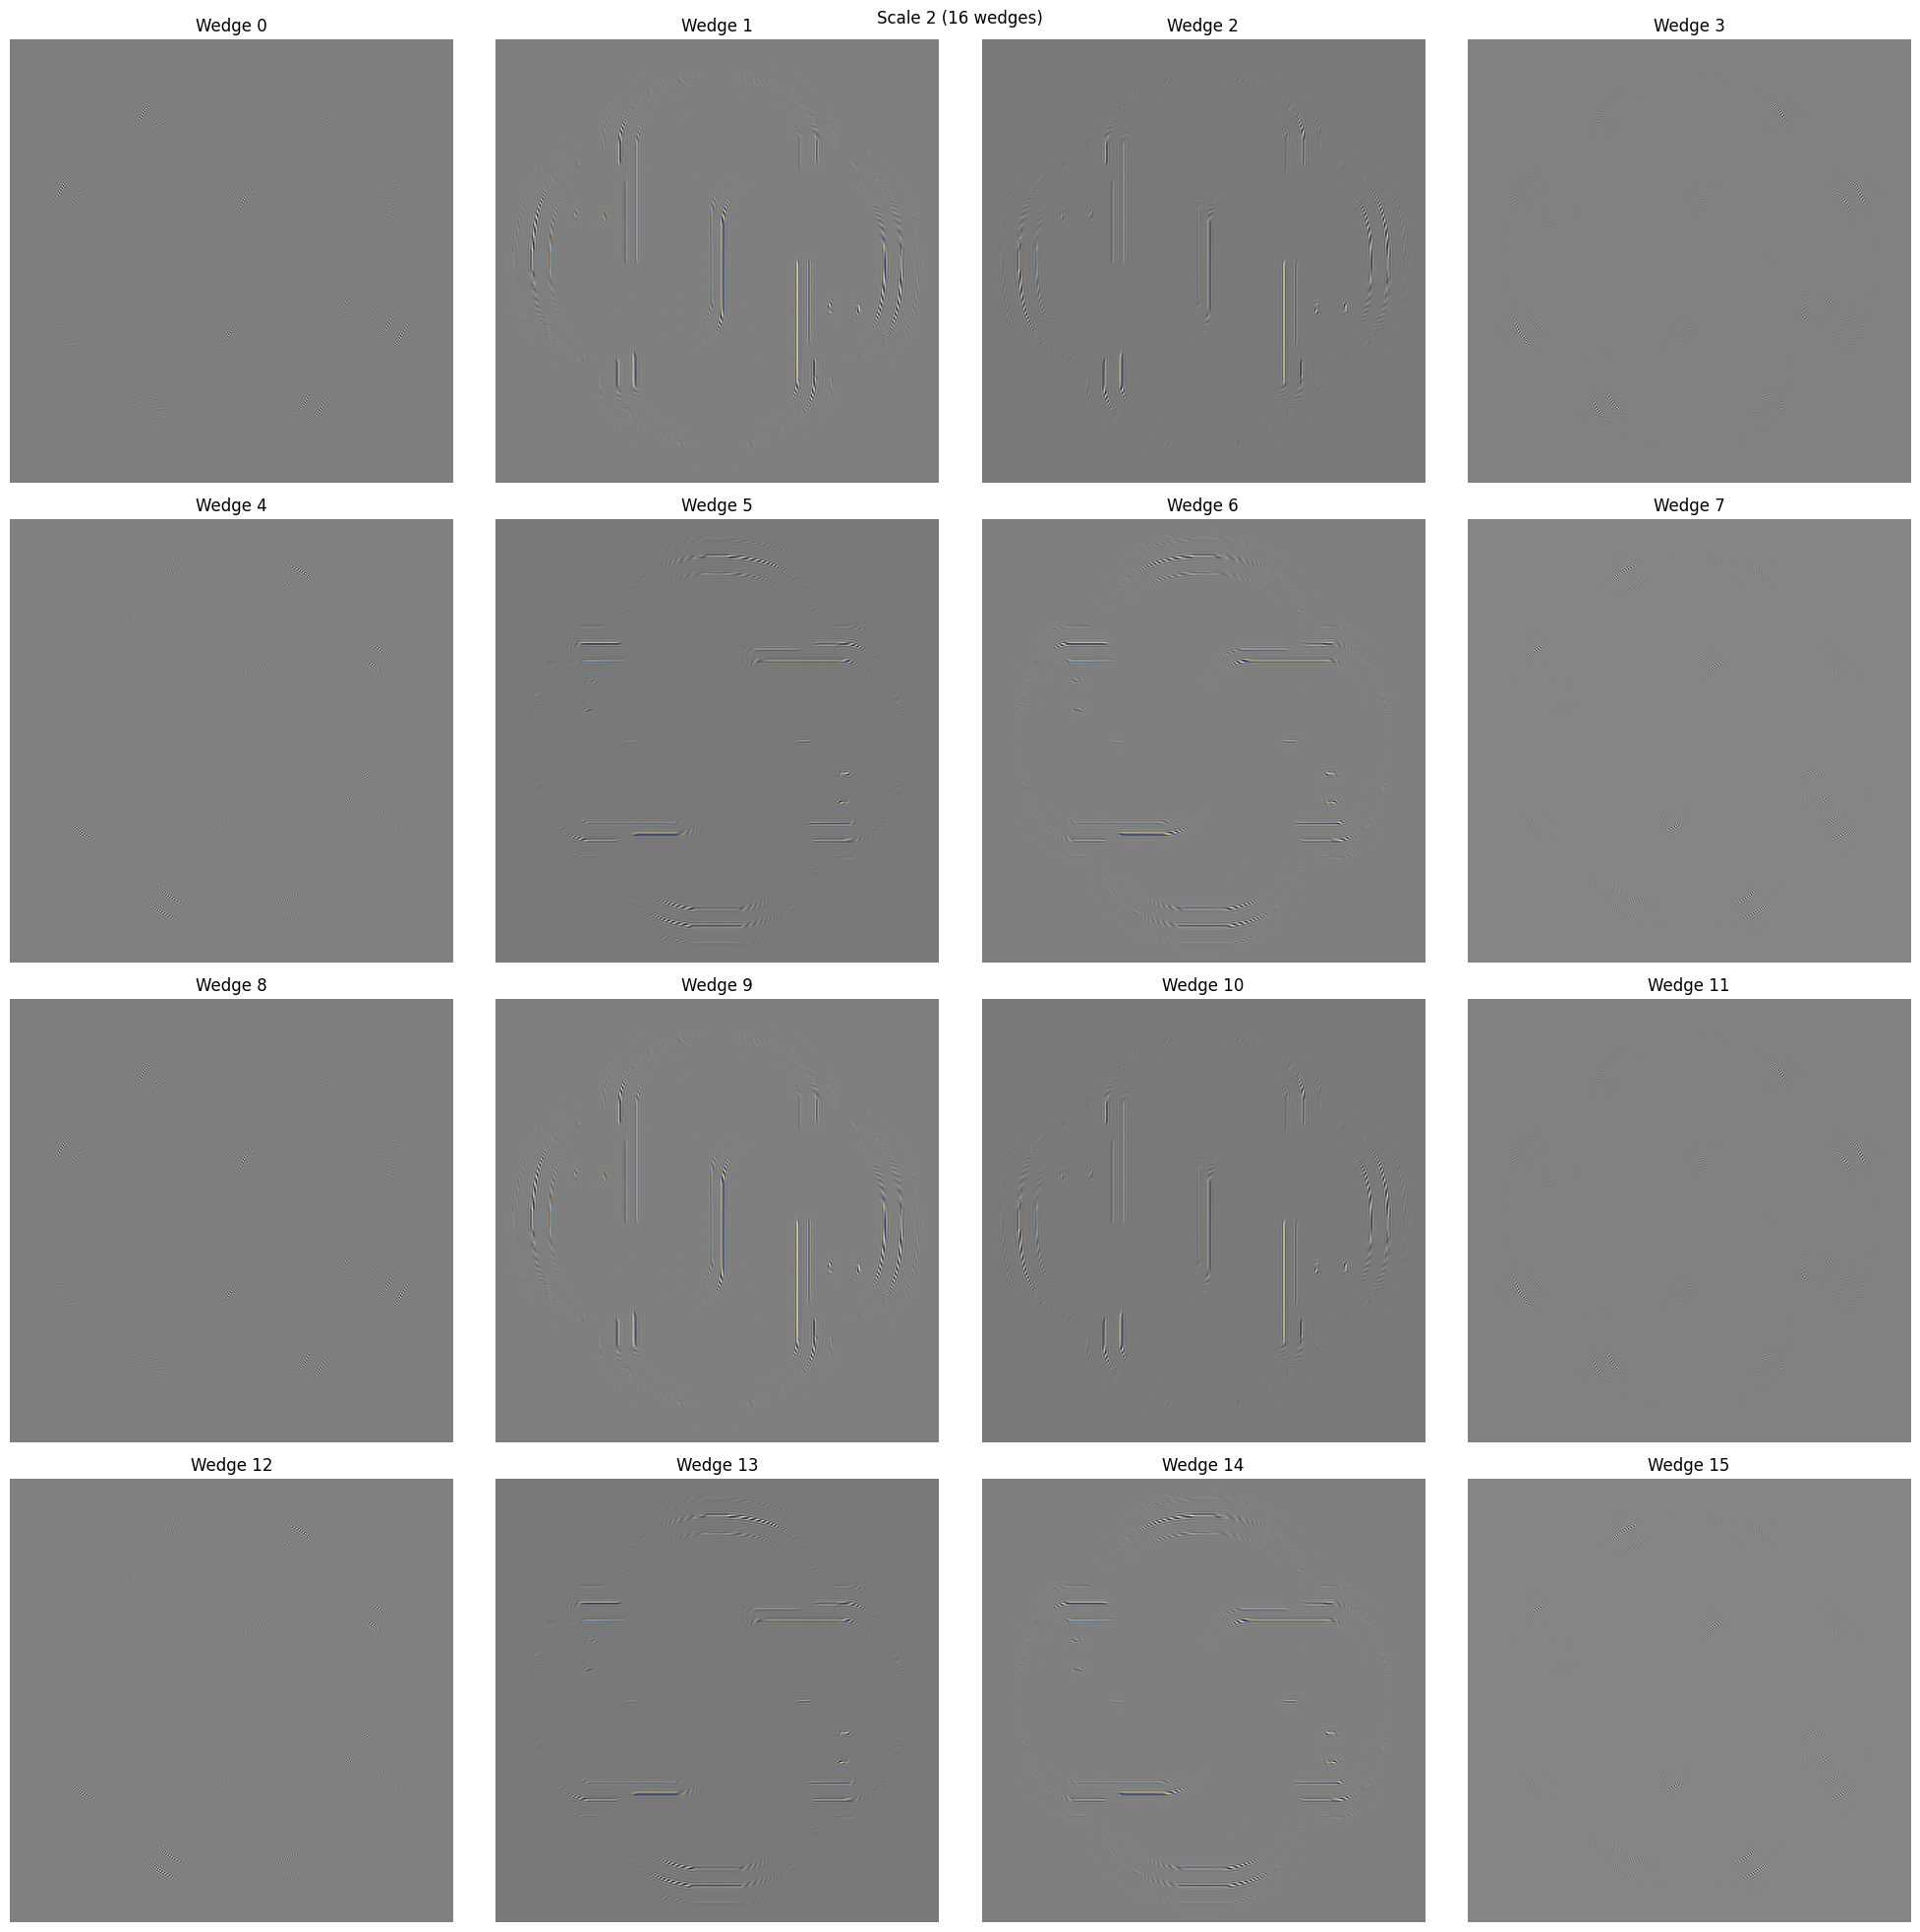

In [28]:
fig_axes = curveshow(
    logo_c,
    kwargs_imshow=dict(extent=[0, 1, 1, 0]),
)

It is interesting to notice that the "color" of the image is only in the coarsest scale because this scale contains the zero frequency aka the DC-component. All other scales add only variations on top os that initial image.

Another interesting aspect of the curvelet transform is that it is very easy to interpret its coefficients. They are essentially a "piece" of the original which varies along a certain preferential direction.

Finally let's see an application of the FDCT to map the preferential direction of events in an image.

In [29]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from curvelops.plot import (
    create_inset_axes_grid,
    create_axes_grid,
    overlay_disks,
)

In [30]:
inputfile = "../testdata/sigmoid.npz"

d = np.load(inputfile)
d = d["sigmoid"]
nx, nz = d.shape
dx, dz = 0.006, 0.005
x, z = np.arange(nx) * dx, np.arange(nz) * dz

vmax = 0.5 * np.max(np.abs(d))

In [31]:
Cop = FDCT2D(d.shape, nbscales=4, nbangles_coarse=8, allcurvelets=False)
d_c = Cop.struct(Cop @ d)

Here we are plotting, overlain on the original input signal the strength of the curvelet coefficients at each scale/wedge. These disks mimic the wedge division we discussed above: the closest to the center, the lower the scale; the angular wedges map to the same place in the $k$-space domain. Consequently, similar to our visualization of the $k_\text{max}$ vectors, we should see that the strongest energy lies *orthogonal* to the preferential dips. As a reminder, this happens because the strongest points in the $k$-space are those where the image varies the most in that direction. So, orthogonally to where it varies the least. We can identify this behavior in the image, especially near the top of the image where the structure is regular.

However, these disks give us even more information than the preferential dip at any arbitrary location. They also can give us an idea of the anisotropy of the image. For example, when there is no preferential direction, or many preferential directions, the image is more isotropic. And this information is provided no only locally in space, but also separated by spatial frequencies.

Of course, even the disks are a aggregate of the full information that the curvelet transform contains, which attests to its power and versatility!

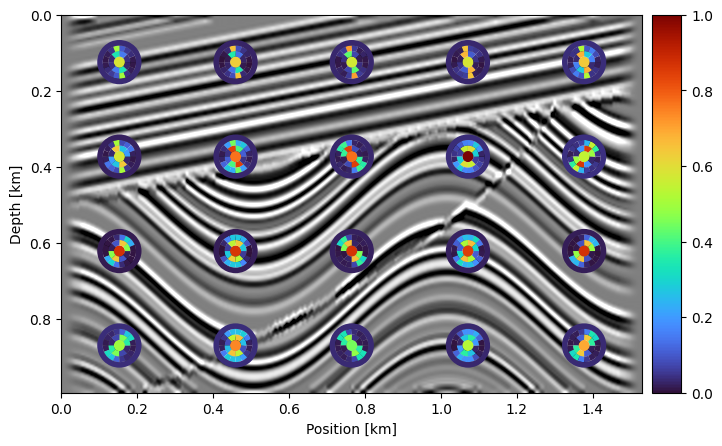

In [32]:
rows, cols = 4, 5
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(
    d.T, vmin=-vmax, vmax=vmax, extent=(x[0], x[-1], z[-1], z[0]), cmap="gray"
)
axesin = create_inset_axes_grid(
    ax, rows, cols, width=0.4, kwargs_inset_axes=dict(projection="polar")
)
overlay_disks(d_c, axesin, linewidth=0.0, cmap="turbo")
ax.set(xlabel="Position [km]", ylabel="Depth [km]")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mpl.colorbar.ColorbarBase(
    cax, cmap=plt.get_cmap("turbo"), norm=mpl.colors.Normalize(vmin=0, vmax=1)
)

### Key Takeaways

* Fourier transform of images give us an idea of the preferential directions of change
* The curvelet transform goes a step beyond that, telling us how the image is varying at each location, in which direction and with which spatial frequency.
* The curvelet transform is traditionally performed with the FDCT (Fast Discrete Curvelet Transform) provided in Python by curvelops and CurveLab
* The FDCT can be used in many areas such as signal processing, and deep learning (see TorchOperator in PyLops).